# (Option 1) Generate data
Run the Matlab engine to call scripts that generate data

In [ ]:
# python -m ipykernel install --user --name=my-virtualenv-name
import matlab.engine
import time
import matplotlib.pyplot as plt
import numpy as np

# Use full browser width
from IPython.core.display import display, HTML
display(HTML(""))

# Show data
eng_start = time.time()
eng = matlab.engine.start_matlab()
print('Engine start took', time.time() - eng_start, 'seconds')

data = []

blur = 1.3
sim_start = time.time()
for i in range(5):
    ground_truth, simulated = eng.simulate(blur, 15, 0, nargout=2)
    
    plt.subplot(121)
    plt.imshow(ground_truth, cmap='gray')
    
    plt.subplot(122)
    plt.imshow(simulated, cmap='gray')
    plt.show()
    
# Most of the time is to set up the connection
print('Simulation took', time.time() - sim_start, 'seconds')

In [2]:
from tqdm import tqdm

# Generate data
N = 200
X, y = [], []

for i in tqdm(range(N)):
    ground_truth, simulated = eng.simulate(blur, 15, 0, nargout=2)
    X += [simulated]
    y += [ground_truth]
    
X, y = np.array(X), np.array(y)

100%|██████████| 200/200 [00:02<00:00, 82.87it/s]


# (Option 2) Load data
Load data saved in a <tt>.mat</tt> file

In [7]:
import scipy.io
dataset_name = 'dataset'
dataset = scipy.io.loadmat(dataset_name + '.mat')[dataset_name]

X = dataset[0]
y = dataset[1]

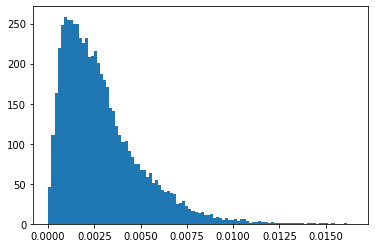

In [8]:
# Look at statistics of data
h2 = plt.hist(X[0].reshape(-1,1), bins = 100, density = True, alpha=1)

# Preprocessing
It might be advantageous to smooth the data and use simple edge detection to crudely highlight the wire.

Here we evaluate some preprocessing (but do not yet apply it to the training set)

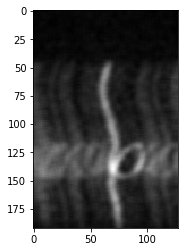

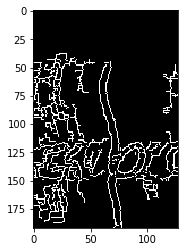

In [9]:
import cv2
ex = X[0]
kernel = np.ones((5,5),np.float32)/(5*5)
ex = cv2.filter2D(ex,-1,kernel)
plt.imshow(ex,cmap = 'gray')
plt.show()

ex = ex - np.min(ex)
ex = 255 * ex / np.max(ex)
ex = np.uint8(ex)
edges = cv2.Canny(ex,20,90)

plt.imshow(edges,cmap = 'gray')
plt.show()

# Intensity-based Segmentation
Here, we use a GMM to do a basic intensity based segmentation

In [11]:
# Segment data
from sklearn.mixture import GaussianMixture
import cv2

# The background and the wire
n_components = 2

model=GaussianMixture(n_components=n_components, means_init=[[0], [5]])

segmentations_gmm = []
segmentations_threshold = []
segmentations_edge = []

for datum in X:
        
    # Threshold segmentation
    segmentations_threshold += [datum > 10]
    
    # Laplace filter
    lp = -cv2.Laplacian(datum, cv2.CV_64F, ksize=15)
    lp = lp - np.min(lp)
    lp = lp / np.max(lp)
    segmentations_edge += [lp]
#     segmentations_edge += [cv2.Sobel(datum,cv2.CV_64F,1,0,ksize=5)]


## Results

Clearly, the GMM is not very good since the noise can have the same intensity as the wire.


In [13]:
# Show first few segmentations
for i, (seg_gmm, seg_thresh, seg_edge, ground_truth, simulated) in enumerate(list(zip(segmentations_gmm, segmentations_threshold, segmentations_edge, y, X))[:3]):
    plt.figure(figsize=(12, 12))
    plt.subplot(141)
    plt.imshow(ground_truth, cmap='gray')
    plt.axis('off')

    plt.subplot(142)
    plt.imshow(simulated, cmap='gray')
    plt.axis('off')

    plt.subplot(143)
    plt.imshow(seg_gmm, cmap='gray')
    plt.axis('off')
    
    plt.subplot(144)
    plt.imshow(seg_thresh, cmap='gray')
    plt.axis('off')
    plt.show()

The Laplace filter followed by a threshold provides very accurate segmenations, with some noise

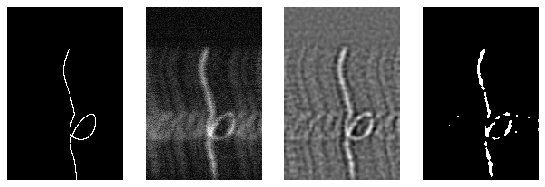

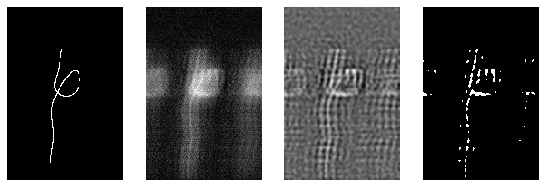

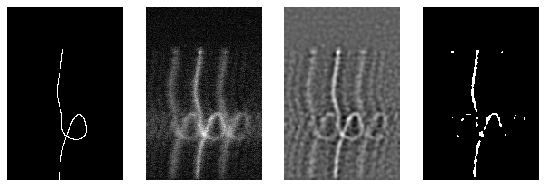

In [16]:
# Show first few segmentations
for i, (seg_edge, ground_truth, simulated) in enumerate(list(zip(segmentations_edge, y, X))[:3]):
    plt.figure(figsize=(12, 12))
    plt.subplot(151)
    plt.imshow(ground_truth, cmap='gray')
    plt.axis('off')

    plt.subplot(152)
    plt.imshow(simulated, cmap='gray')
    plt.axis('off')

    plt.subplot(153)
    plt.imshow(seg_edge, cmap='gray')
    plt.axis('off')
    
    plt.subplot(154)
    plt.imshow(seg_edge > (0.62), cmap='gray')
    plt.axis('off')
    
    plt.show()

# Random Forest Segmentation
This is the first machine learning method we are using.

### Create the dataset
Random forests predict each patch of the image by taking as input a larger, surrounding patch (to capture context)<br>
Thus, <br>
<b>y</b>: Patches of the image <br>
<b>X</b>: Larger patches centered over each <b>y</b>

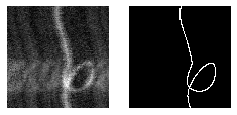

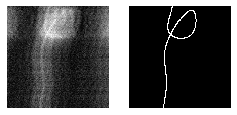

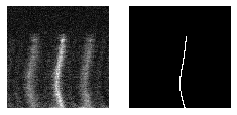

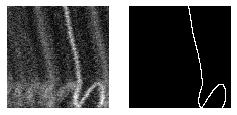

In [26]:
from random import randint

n_patches = 3000
patch_dim = 101
patches_sim, patches_gt = [], []
for i in range(n_patches):
    sample_train = X[i % len(X)]
    sample_test  = y[i % len(y)]
    tl = np.array([randint(0, sample_train.shape[i] - patch_dim - 1) for i in [0, 1]])
    patches_sim.append(sample_train[tl[0]:tl[0] + patch_dim, tl[1]:tl[1] + patch_dim])
    patches_gt.append(sample_test[tl[0]:tl[0] + patch_dim, tl[1]:tl[1] + patch_dim])

for i, (patch_sim, patch_gt) in enumerate(list(zip(patches_sim, patches_gt))[:4]):
    plt.figure(figsize=(4, 4))
    plt.subplot(121)
    plt.imshow(patch_sim, cmap='gray')
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(patch_gt, cmap='gray')
    plt.axis('off')
    
patches_sim, patches_gt = np.array(patches_sim), np.array(patches_gt)
w = 3
c = patch_dim // 2
patch_labels = np.array([p[c - w:c + w, c - w:c + w] for p in patches_gt])
X_patches = np.array(patches_sim).reshape(n_patches,-1)
y_patches = np.array(patch_labels).reshape(n_patches,-1)

### Train random forest classifier

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

print('Class balance: ', np.sum(patch_labels) / np.prod(patch_labels.shape))
clf = RandomForestClassifier(max_depth=100)

X_train, X_test, y_test, y_train = train_test_split(X_patches, y_patches, test_size=0.15, random_state=0)

clf.fit(X_train, y_test)
preds = clf.predict(X_test)

Class balance:  0.04975


/Users/Robert/Documents/venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Make prediction on image
To actually segment an image, we must do so patch-by-patch<br>
Then collect the patches into the final segmentation

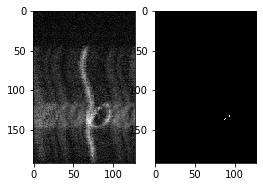

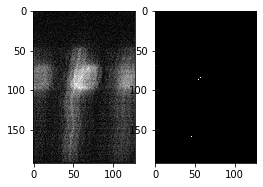

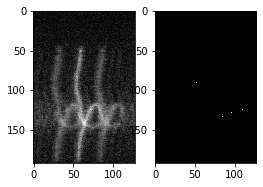

In [33]:
def rf_predict(image):
    test_sample = np.array(image)
    sample = np.pad(test_sample, patch_dim // 2 - w, mode='reflect')
    
    total_pred = np.zeros_like(test_sample)
    for i in range(w, test_sample.shape[0] - 2*w, 2 * w):
        for j in range(w, test_sample.shape[1] - 2*w, 2 * w):
            patch = sample[i:i + patch_dim, j:j + patch_dim]
            pred = clf.predict(patch.reshape(1,-1))

            total_pred[i-w:i+w,j-w:j+w] = pred.reshape(6,6)
    return total_pred

for i in range(3):
    pred = rf_predict(X[i])
    plt.figure(figsize=(4, 4))
    plt.subplot(121)
    plt.imshow(X[i], cmap='gray')
    plt.subplot(122)
    plt.imshow(pred, cmap='gray')

# U-Net Segmentation

A more sophisticated approach is needed to segment the wires from the images. Multiple ones are available but the first one used is the U-Net. 



Use pytorch to define the unet model 

In [11]:
# import modules (download with pip install first if not on local. Type on terminal: pip install <module name>)

import torch
import torch.nn as nn
import torch.nn.functional as F #contains some useful functions like activation functions & convolution operations you can use

device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")
print("Using",device,"...")

Using cpu ...


In [12]:
# At each step along the contracting and expansive paths, UNET has 2 convolutions grouped together 
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   

In [13]:
# implement model 
class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(1, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

In [14]:
# install torchvision first
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

In [15]:
from tqdm import tqdm

# implement Simulation of Dataset 
class SimDataset(Dataset):
    def __init__(self, count, transform=None):
        _simulated, _ground_truth = [], []
        for i in tqdm(range(count)):
            ground_truth, simulated = eng.simulate(1.3, 15, 0, nargout=2)
            _simulated += [simulated]
            _ground_truth += [ground_truth]

        self.input_images, self.target_masks = np.array(_simulated), np.array(_ground_truth)
        self.transform = transform
    
    def __len__(self):
        return len(self.input_images)
    
    def __getitem__(self, idx):        
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)
        
        return [image, mask]

# Tranform into pytorch tensors 
trans = transforms.Compose([
    transforms.ToTensor(),
])

# Create a train set and a validation set, each with input images (simulation data) and target masks (ground truth data)
train_set = SimDataset(100,transform = trans)
val_set = SimDataset(20,transform = trans)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 25

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

100%|██████████| 20/20 [00:00<00:00, 30.51it/s]


{'train': 100, 'val': 20}

In [16]:
# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)
for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

torch.Size([25, 1, 256, 192]) torch.Size([25, 256, 192])
8.697873944564214e-07 0.02109336027394553 0.002554960706174774 0.002164863822560459
False True 0.09334716796875 0.2909183290907673


In [17]:
# install torchsummary first
from torchsummary import summary

model = UNet(2)
model = model.to(device)

print("MODEL ARCHITECTURE ...")
summary(model, input_size=(1,256,192))

MODEL ARCHITECTURE ...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 192]             640
              ReLU-2         [-1, 64, 256, 192]               0
            Conv2d-3         [-1, 64, 256, 192]          36,928
              ReLU-4         [-1, 64, 256, 192]               0
         MaxPool2d-5          [-1, 64, 128, 96]               0
            Conv2d-6         [-1, 128, 128, 96]          73,856
              ReLU-7         [-1, 128, 128, 96]               0
            Conv2d-8         [-1, 128, 128, 96]         147,584
              ReLU-9         [-1, 128, 128, 96]               0
        MaxPool2d-10          [-1, 128, 64, 48]               0
           Conv2d-11          [-1, 256, 64, 48]         295,168
             ReLU-12          [-1, 256, 64, 48]               0
           Conv2d-13          [-1, 256, 64, 48]         590,080
             ReL

In [18]:
# Import other useful libraries 
from collections import defaultdict
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

In [19]:
loss_function = nn.MSELoss()

In [20]:
def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs.float())
                    loss = loss_function(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [21]:
num_class = 2

model = UNet(num_class).float()
model = model.to(device)

optimizer_ft = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9) 

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=40)

Epoch 0/39
----------
LR 0.01


/Users/maricamuffoletto/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/Users/maricamuffoletto/anaconda3/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([25, 256, 192])) that is different to the input size (torch.Size([25, 2, 256, 192])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (2) must match the size of tensor b (25) at non-singleton dimension 1

In [ ]:
# Still to implement def val_model

In [ ]:
# Plot validation loss and accuracy
plt.plot(np.arange(1,epochs+1), loss_validation)
plt.title('validation loss')

plt.plot(np.arange(1,epochs+1), acc_validation)
plt.title('validation accuracy');